In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *
from pytorch_inferno.inferno import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [7]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=1, float_l=0, aug_alpha=False),LossTracker(),SaveBest('weights/best_ie1.h5'),EarlyStopping(10)])

1: Train=504.35785919189453 Valid=423.5298406982422
2: Train=404.7738626098633 Valid=400.80330749511717
3: Train=385.3933416748047 Valid=388.0177783203125
4: Train=377.1150714111328 Valid=379.96282653808595
5: Train=372.7078076171875 Valid=371.62018127441405
6: Train=364.22801483154296 Valid=365.9489404296875
7: Train=355.2407814025879 Valid=364.13488708496095
8: Train=353.3391104125977 Valid=358.0657653808594
9: Train=348.9981173706055 Valid=353.8390539550781
10: Train=345.41054168701174 Valid=350.10839782714845
11: Train=342.3892028808594 Valid=346.6910162353516
12: Train=338.85518524169925 Valid=344.1969946289062
13: Train=336.7776107788086 Valid=344.6599871826172
14: Train=335.8159768676758 Valid=339.13084716796874
15: Train=332.17431411743166 Valid=337.98002197265623
16: Train=330.3574964904785 Valid=335.43391479492186
17: Train=328.26652099609373 Valid=334.49607727050784
18: Train=325.8951824951172 Valid=332.67150024414065
19: Train=323.8613429260254 Valid=329.8206579589844
20: T

In [8]:
model.save('weights/Inferno_Test_exact_bm1.h5')

In [9]:
model.load('weights/Inferno_Test_exact_bm1.h5')

# Results

## BM 0

In [10]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [11]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,3,1.0
1,0,1.0
2,0,1.0
3,5,1.0
4,0,1.0


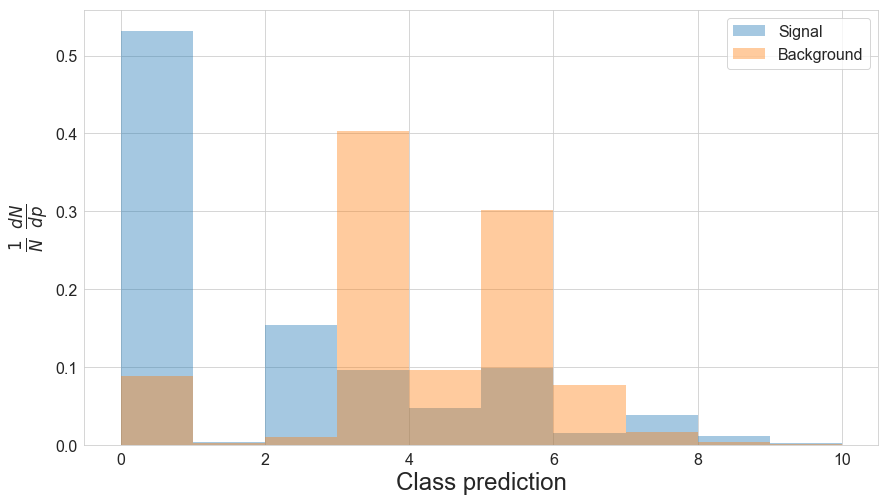

In [12]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [13]:
bin_preds(df)

In [14]:
df.head()

,pred,gen_target,pred_bin
0,3,1.0,3
1,0,1.0,0
2,0,1.0,0
3,5,1.0,5
4,0,1.0,0


In [15]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [16]:
f_s.sum(), f_b.sum()

(tensor(1.0000), tensor(1.0000))

In [17]:
f_s, f_b

(tensor([0.5322, 0.0042, 0.1541, 0.0957, 0.0475, 0.0987, 0.0158, 0.0383, 0.0114,
         0.0022]),
 tensor([0.0883, 0.0022, 0.0097, 0.4037, 0.0956, 0.3021, 0.0769, 0.0167, 0.0041,
         0.0008]))

In [18]:
asimov = (50*f_s)+(1000*f_b)

In [19]:
asimov, asimov.sum()

(tensor([114.9051,   2.3931,  17.3753, 408.5330,  97.9658, 307.0708,  77.6679,
          18.5833,   4.6481,   0.8576]), tensor(1049.9999))

In [20]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([28.14354897, 27.99840927, 27.85944366, 27.72633743, 27.5986824 ,
       27.47738457, 27.36149979, 27.2509079 , 27.14590263, 27.04631805,
       26.95198059, 26.86284447, 26.77889252, 26.70030785, 26.62645912,
       26.55740547, 26.49344444, 26.4342804 , 26.37983704, 26.33003807,
       26.28484726, 26.24429703, 26.20799255, 26.1765976 , 26.14913368,
       26.12643433, 26.10764313, 26.09346771, 26.08310318, 26.07697296,
       26.07490921, 26.07690048, 26.08291626, 26.09257126, 26.10671997,
       26.12427521, 26.14563751, 26.17101097, 26.20003128, 26.23270416,
       26.26907921, 26.30900955, 26.35232162, 26.39906883, 26.44964981,
       26.50362015, 26.5608139 , 26.6217289 , 26.68549538, 26.75274849,
       26.82344818, 26.89726639, 26.97442245, 27.05456543, 27.13820267,
       27.22429657, 27.31408119, 27.40655899, 27.50216293, 27.60092545,
       27.70275879])

In [21]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [22]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

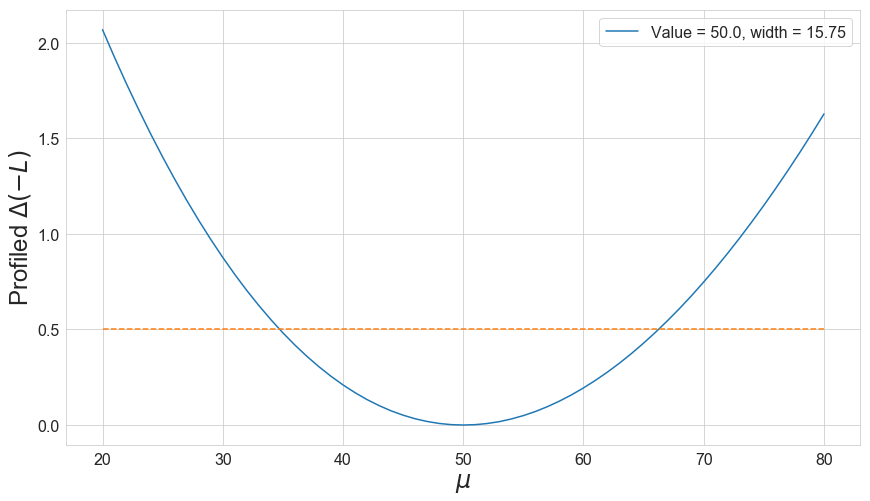

In [23]:
plot_likelihood(y-y.min())

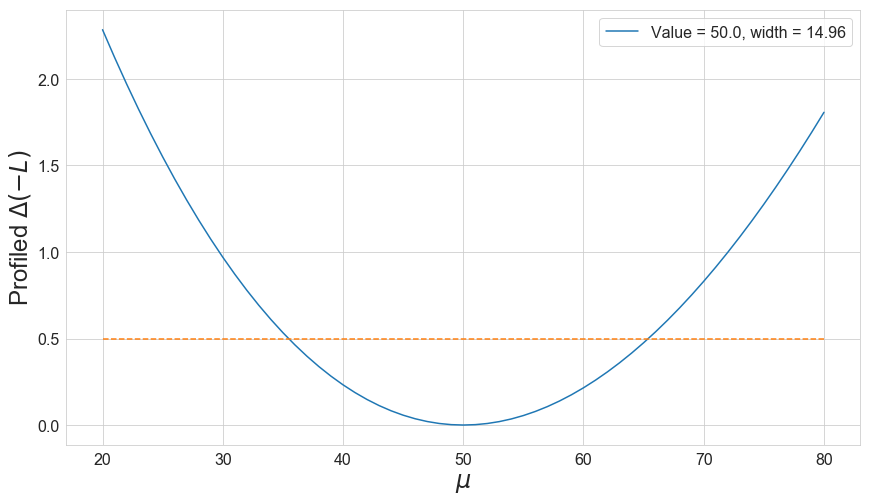

In [24]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [25]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [26]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [27]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,3,1.0,3,3,3,3,3,3,3,3,3,3,3
1,0,1.0,0,0,0,0,0,0,0,0,0,0,0
2,0,1.0,0,0,0,0,0,0,0,0,0,0,0
3,5,1.0,5,5,5,5,5,5,5,5,5,5,5
4,0,1.0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,3,0.0,3,3,3,3,3,3,3,3,3,3,3
999996,3,0.0,3,3,3,3,3,3,3,3,3,3,3
999997,0,0.0,0,0,0,0,0,0,0,0,0,0,0
999998,0,0.0,0,5,5,0,0,0,0,0,0,0,0


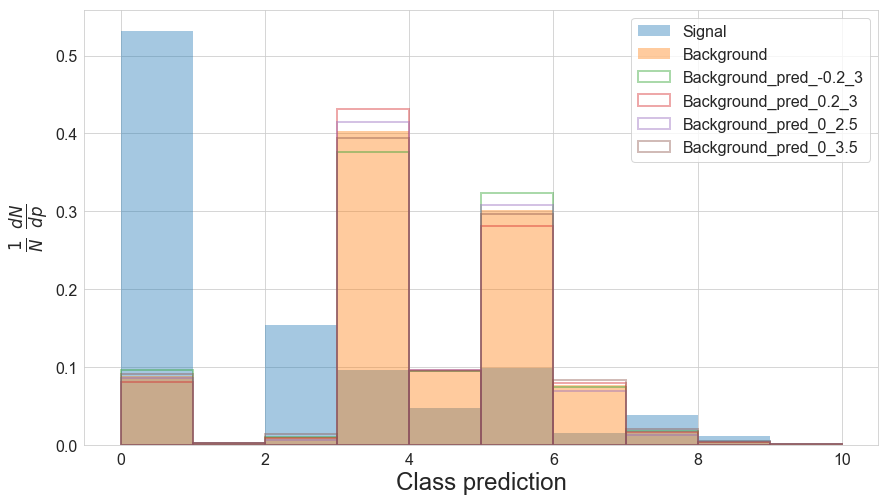

In [28]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([0.0933, 0.0023, 0.0073, 0.3867, 0.0954, 0.3290, 0.0662, 0.0141, 0.0048,
        0.0010])
tensor([0.0957, 0.0026, 0.0106, 0.3758, 0.0947, 0.3236, 0.0740, 0.0177, 0.0045,
        0.0009])
tensor([0.0979, 0.0028, 0.0145, 0.3667, 0.0935, 0.3178, 0.0800, 0.0217, 0.0044,
        0.0008])
tensor([0.0858, 0.0019, 0.0064, 0.4147, 0.0963, 0.3076, 0.0692, 0.0130, 0.0043,
        0.0009])
tensor([0.0883, 0.0022, 0.0097, 0.4037, 0.0956, 0.3021, 0.0769, 0.0167, 0.0041,
        0.0008])
tensor([0.0904, 0.0025, 0.0136, 0.3947, 0.0944, 0.2964, 0.0829, 0.0206, 0.0039,
        0.0006])
tensor([0.0785, 0.0017, 0.0056, 0.4428, 0.0969, 0.2860, 0.0714, 0.0123, 0.0039,
        0.0009])
tensor([0.0810, 0.0020, 0.0088, 0.4319, 0.0962, 0.2806, 0.0791, 0.0160, 0.0037,
        0.0008])
tensor([0.0831, 0.0023, 0.0127, 0.4228, 0.0950, 0.2748, 0.0851, 0.0199, 0.0035,
        0.0006])


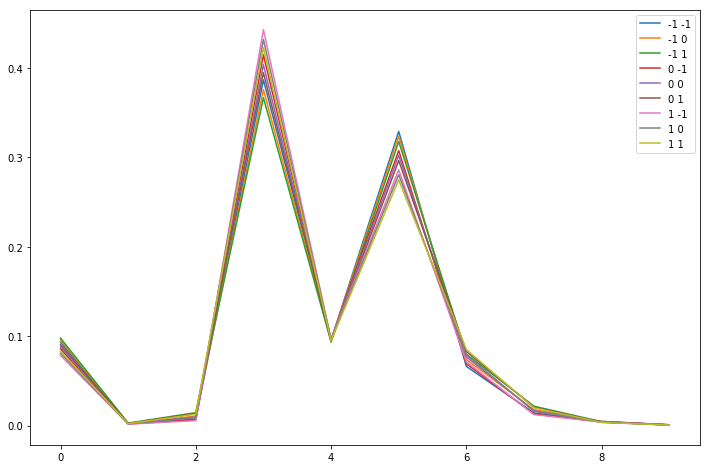

In [29]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [30]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [31]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [32]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [33]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [34]:
nll = to_np(nll)

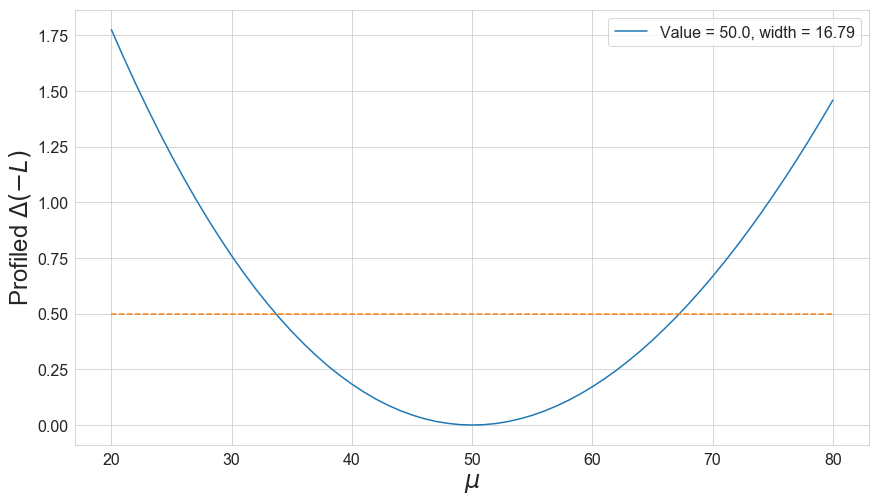

In [35]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [36]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [37]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [38]:
nll = to_np(nll)

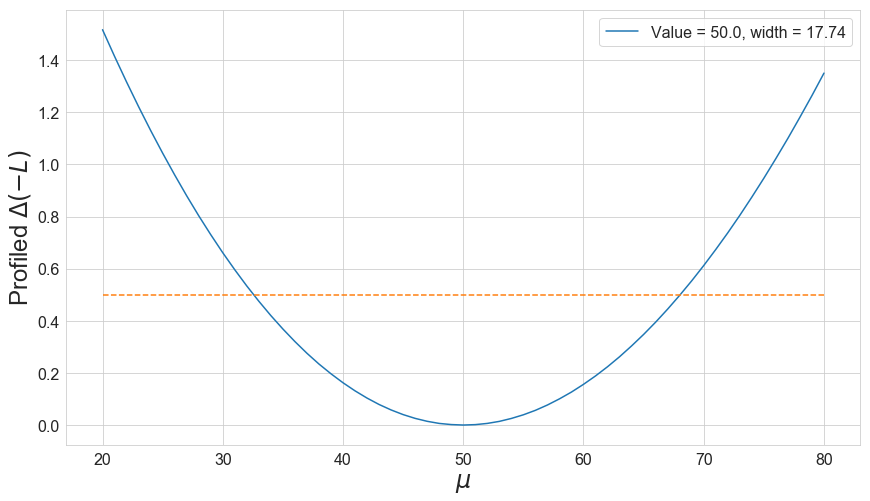

In [39]:
plot_likelihood(nll-nll.min())

## BM 2

In [40]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [41]:
nll = to_np(nll)

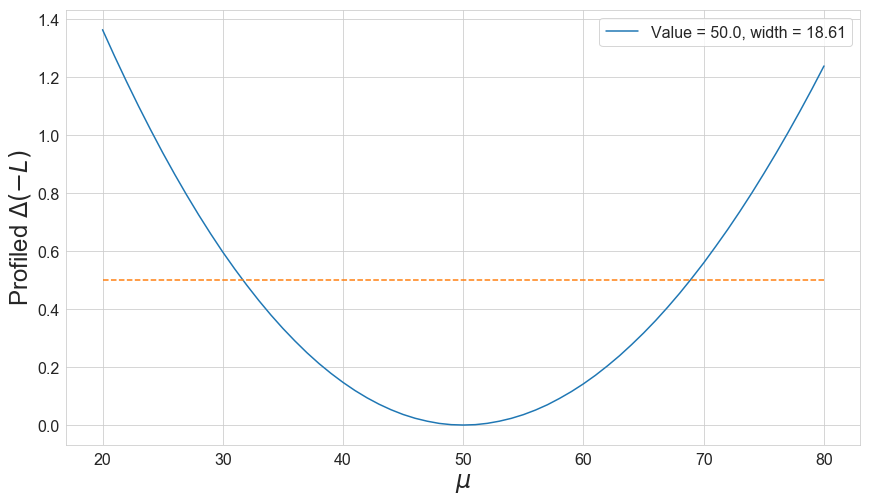

In [42]:
plot_likelihood(nll-nll.min())